In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import networkx as nx

______________________________

In [4]:
network = 'tarbase'
ppi_network = 'preppi'
target_homology = 'mix'

remove_SSD_pre_2R = False
keep_SSD_pre_2R = False

if remove_SSD_pre_2R and keep_SSD_pre_2R:
	raise ValueError("Cannot both remove and keep pre-2R SSD pairs. Choose one option or remove both.")

if remove_SSD_pre_2R:
	s = 'post_2R'
elif keep_SSD_pre_2R:
	s = 'pre_2R'
else:
	s = ''

remove_large_fam = True
if remove_large_fam:
	max_n_nodes = 4
	s += f'cc_largerthan{str(max_n_nodes)}_removed'

In [5]:
if target_homology == 'wgd':
	file_path_1 = f'./output/{network}_om.z_1000.TF.tsv'
	file_path_2 = f'./output/{network}_pm_mixed.z_1000.TF.tsv'
elif target_homology == 'ssd':
	file_path_1 = f'./output/{network}_om_mixed.z_1000.TF.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.TF.tsv'
elif target_homology == 'mix':
	file_path_1 = f'./output/{network}_om.z_1000.TF.tsv'
	file_path_2 = f'./output/{network}_pm.z_1000.TF.tsv'
else:
	raise ValueError("target_homology must be either 'wgd', 'ssd' or 'mix'")

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [6]:
mirna_pair_lca_file_path = '../../3_retrieve_Hsa_paralogs/all_hsa_ensembl_paralogmirna_clean.tsv'
df_mirna_pair_lca = pd.read_csv(mirna_pair_lca_file_path, sep='\t', header=None)
pair_lca_dict = {}
for _, row in df_mirna_pair_lca.iterrows():
	pair_lca_dict[(row[1], row[3])] = row[4]
	pair_lca_dict[(row[3], row[1])] = row[4]

In [7]:
ordered_lca = {
	'Eumetazoa': 0,
	'Bilateria': 1,
	'Nephrozoa': 2,
	'Chordata': 3,
	'Olfactores': 4,
	'Vertebrata': 5,
	'Gnathostomata': 6,
	'Osteichthyes': 7,
	'Euteleostomi': 8,
	'Sarcopterygii': 9,
	'Tetrapoda': 10,
	'Amniota': 11,
	'Mammalia': 12,
	'Theria': 13,
	'Eutheria': 14,
	'Boroeutheria': 15,
	'Euarchontoglires': 16,
	'Primates': 17,
	'Simiiformes': 18,
	'Catarrhini': 19,
	'Hominidae': 20,
	'Homo_sapiens': 21
}

reverted_ordered_lca = {v: k for k, v in ordered_lca.items()}

In [8]:
df_wgd = df_1
df_ssd = df_2

In [9]:
def add_lca(df):
    df['lca'] = df.apply(lambda row: pair_lca_dict.get((row['miRNA_1'], row['miRNA_2'])), axis=1)
    return df

df_wgd_lca = add_lca(df_wgd)
df_ssd_lca = add_lca(df_ssd)

In [10]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
1,MIR100,MIR10B,136,141,6,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
2,MIR100,MIR125A,136,306,8,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
3,MIR100,MIR125B1,136,270,7,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
4,MIR100,MIR125B2,136,367,12,0.001,0.031607,0,1000,-0.03163859985841663,1.0,Bilateria
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,0.029,0.167806,1,29,5.7864288313855265,8.059108935754011e-13,Bilateria
1379,MIRLET7F1,MIRLET7I,543,478,436,0.016,0.133207,1,15,7.387021006519912,0.0,Euteleostomi
1380,MIRLET7F2,MIRLET7G,519,620,453,0.025,0.156125,1,25,6.244997998398398,1.2212453270876722e-15,Vertebrata
1381,MIRLET7F2,MIRLET7I,519,478,436,0.027,0.168140,1,26,5.786850396234624,5.258016244624741e-13,Bilateria


In [11]:
print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [12]:
df_ssd_lca

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca
0,MIR100,MIR10A,136,272,7,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
1,MIR100,MIR10B,136,141,6,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
2,MIR100,MIR125A,136,306,8,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
3,MIR100,MIR125B1,136,270,7,0.000,0.000000,0,1000,sigma_err,1.0,Bilateria
4,MIR100,MIR125B2,136,367,12,0.001,0.031607,0,1000,-0.03163859985841663,1.0,Bilateria
...,...,...,...,...,...,...,...,...,...,...,...,...
1378,MIRLET7F1,MIRLET7G,543,620,453,0.029,0.167806,1,29,5.7864288313855265,8.059108935754011e-13,Bilateria
1379,MIRLET7F1,MIRLET7I,543,478,436,0.016,0.133207,1,15,7.387021006519912,0.0,Euteleostomi
1380,MIRLET7F2,MIRLET7G,519,620,453,0.025,0.156125,1,25,6.244997998398398,1.2212453270876722e-15,Vertebrata
1381,MIRLET7F2,MIRLET7I,519,478,436,0.027,0.168140,1,26,5.786850396234624,5.258016244624741e-13,Bilateria


In [13]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

if remove_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[~df_ssd_lca['lca'].isin(pre_2R_clades)]
if keep_SSD_pre_2R:
	df_ssd_lca = df_ssd_lca[df_ssd_lca['lca'].isin(pre_2R_clades)]

print("Number of WGD pairs: ", len(df_wgd_lca))
print("Number of SSD pairs: ", len(df_ssd_lca))

Number of WGD pairs:  113
Number of SSD pairs:  1383


In [14]:
def remove_large_cc(df, max_size):
    df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['miRNA_1'], row['miRNA_2'])

    # Identify connected components
    large_components = [comp for comp in nx.connected_components(G) if len(comp) > max_size]

    if not large_components:
        return df

    # Process each large component separately
    indices_to_keep = set()

    for comp in large_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        top_pairs = comp_df.nlargest(max_size, 'Z-score')
        #indices_to_keep.update(top_pairs.index)

    # Identify edges to retain from small components
    small_components = [comp for comp in nx.connected_components(G) if len(comp) <= max_size]
    for comp in small_components:
        comp_df = df[(df['miRNA_1'].isin(comp)) & (df['miRNA_2'].isin(comp))]
        indices_to_keep.update(comp_df.index)

    return df.loc[sorted(indices_to_keep)].reset_index(drop=True)

In [15]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA_1']
		mirna2 = row['miRNA_2']
		if mirna1 != mirna2:
			mirna_pairs.add(tuple(sorted([mirna1, mirna2])))

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA_1'], row['miRNA_2']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd_lca = remove_mirna_pairs(df_ssd_lca, df_wgd_lca)

print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd_lca))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd_lca))

Number of WGD pairs after removing miRNA pairs from SSD:  113
Number of SSD pairs after removing miRNA pairs from SSD:  1271


In [16]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_bifan" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_bifan == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_bifan != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_bifan'] != 0)
    df = df[~mask_remove]

    return df

if remove_large_fam:
	max_n_nodes = 4
	df_ssd_lca_parsed = remove_large_cc(remove_sigma_err(df_ssd_lca), max_n_nodes)
	df_wgd_lca_parsed = remove_large_cc(remove_sigma_err(df_wgd_lca), max_n_nodes)
else:
	df_ssd_lca_parsed = remove_sigma_err(df_ssd_lca)
	df_wgd_lca_parsed = remove_sigma_err(df_wgd_lca)

/tmp/ipykernel_6813/4003812063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')
/tmp/ipykernel_6813/4003812063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Z-score'] = pd.to_numeric(df['Z-score'], errors='coerce')


In [17]:
df_wgd_lca_zscores = df_wgd_lca_parsed['Z-score'].astype(float)
df_ssd_lca_zscores = df_ssd_lca_parsed['Z-score'].astype(float)

df_wgd_lca_nbifan = df_wgd_lca_parsed['n_relevant_bifan'].astype(int)
df_ssd_lca_nbifan = df_ssd_lca_parsed['n_relevant_bifan'].astype(int)

In [18]:
n_wgd = len(df_wgd_lca_zscores)
n_ssd = len(df_ssd_lca_zscores)

print("n_wgd in the boxplot: ", n_wgd)
print("n_ssd in the boxplot: ", n_ssd)

n_wgd in the boxplot:  108
n_ssd in the boxplot:  48


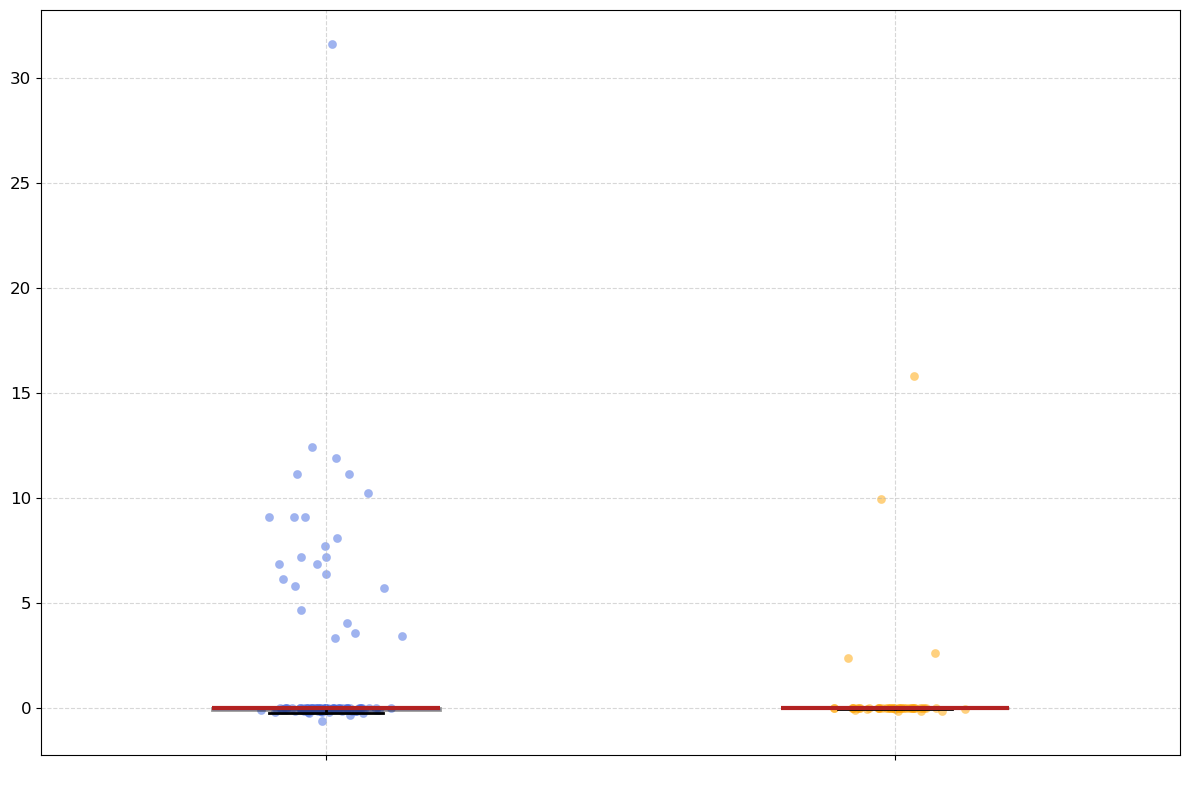

Number of WGD pairs: 108
Number of SSD pairs: 48


In [19]:
data = [df_wgd_lca_zscores, df_ssd_lca_zscores]
positions = [0, 1]
colors = ['royalblue', 'orange']

plt.figure(figsize=(12, 8))

box = plt.boxplot(data, 
                  positions=positions, 
                  widths=0.4,
                  patch_artist=True, 
                  showfliers=False)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(2)
    patch.set_alpha(0.4)
    
for element in ['whiskers', 'caps']:
    for line in box[element]:
        line.set_linewidth(2)
        line.set_color('black')
        
for element in ['medians']:
    for line in box[element]:
        line.set_linewidth(3)
        line.set_color('firebrick')

for i, (scores, color) in enumerate(zip(data, colors)):
    jittered_x = np.random.normal(loc=positions[i], scale=0.05, size=len(scores))
    plt.scatter(jittered_x, scores, alpha=0.5, color=color, linewidth=0.2, label=['', ''][i])

plt.xticks(positions, [' ', ' '], fontsize=100)
#plt.ylim(-3, 75)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

print(f"Number of WGD pairs: {len(df_wgd_lca_parsed)}")
print(f"Number of SSD pairs: {len(df_ssd_lca_parsed)}")

In [20]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_lca_zscores, df_ssd_lca_zscores)
print(f"KS test results with parameters:\nnetwork={network}\ntarget_homology={target_homology}\nremove_pre_2R={remove_SSD_pre_2R}")
print(100 * "=")
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS test results with parameters:
network=tarbase
target_homology=mix
remove_pre_2R=False
KS statistic: 0.28703703703703703, p-value: 0.006592028023950027


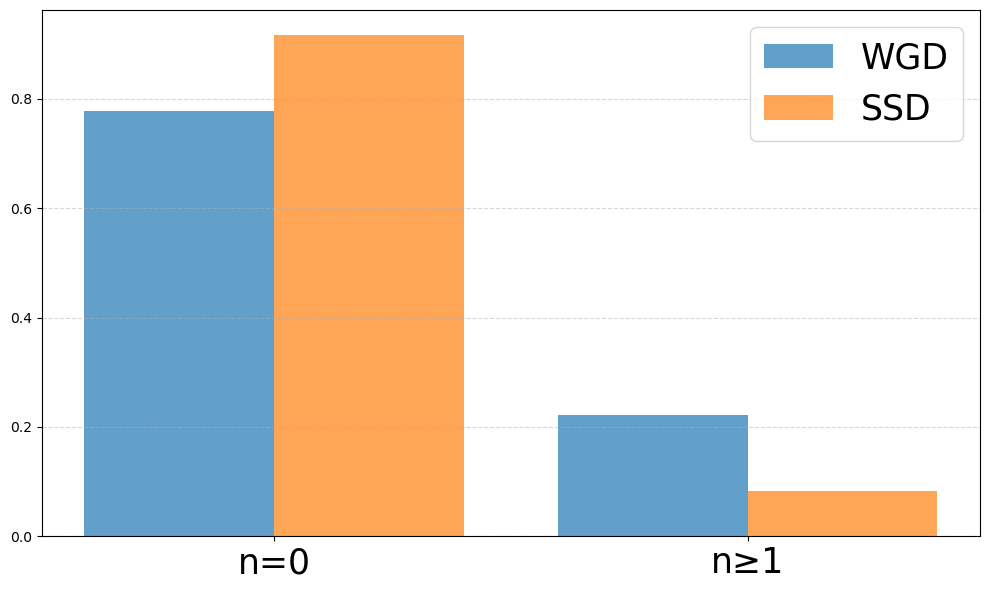

In [21]:
labels = ['n=0', 'n≥1']

def bin_bifans(count, labels=labels):
    if count == 0:
        return labels[0]
    else:
        return labels[1]

# Bin the counts
wgd_binned = pd.Series(df_wgd_lca_nbifan).apply(bin_bifans)
ssd_binned = pd.Series(df_ssd_lca_nbifan).apply(bin_bifans)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(labels, fill_value=0)

x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels, fontsize=25)
plt.xlabel('')
plt.title('')
plt.legend(fontsize=25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

________________________________________

## Subgenome analysis

In [22]:
subg_file = '../../1.1_retrieve_Hsa_ohnomirnas/gnathostomata_ohnolog_reference_singlecol.gene.tsv'
df_subg = pd.read_csv(subg_file, sep='\t', header=None)
cols = ['miRNA', 'subgenome', 'CLG']
df_subg.columns = cols
df_subg

,miRNA,subgenome,CLG
0,MIR1-1,1beta,J
1,MIR1-2,1alpha,J
2,MIR100,1beta,A
3,MIR101-1,1alpha,L
4,MIR101-2,2alpha,L
...,...,...,...
163,MISSING,2beta,J
164,MISSING,2beta,L
165,MISSING,2beta,M
166,MISSING,2beta,N


In [23]:
def label_subgenome(df_dup, df_subg, prefix):
    # Create a dictionary from df_subg (miRNA -> subgenome)
    subg_dict = dict(zip(df_subg['miRNA'], df_subg['subgenome']))

    # Function to translate and label each miRNA
    def translate_miRNA(miRNA):
        miRNA_clean = miRNA.replace(prefix, "")
        return subg_dict.get(miRNA_clean, 'unknown')

    # Apply the translation to miRNA_1 and miRNA_2
    df_dup[f'subg_1'] = df_dup['miRNA_1'].apply(translate_miRNA)
    df_dup[f'subg_2'] = df_dup['miRNA_2'].apply(translate_miRNA)

    return df_dup

df_wgd_lca_parsed_subg = label_subgenome(df_wgd_lca_parsed, df_subg, '')

/tmp/ipykernel_6813/2356517185.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dup[f'subg_1'] = df_dup['miRNA_1'].apply(translate_miRNA)
/tmp/ipykernel_6813/2356517185.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dup[f'subg_2'] = df_dup['miRNA_2'].apply(translate_miRNA)


In [24]:
df_wgd_lca_parsed_subg

,miRNA_1,miRNA_2,n_tar_1,n_tar_2,n_common_targets,mu,sigma,n_relevant_bifan,n_maj_true,Z-score,pValue (nm size=1000),lca,subg_1,subg_2
0,MIR101-1,MIR101-2,190,159,159,0.000,0.000000,0,1000,0.000000,1.0,Euteleostomi,1alpha,2alpha
1,MIR103A1,MIR103A2,950,1075,950,0.175,0.412765,3,1,6.844087,8.558861397389705e-10,Vertebrata,2beta,2alpha
2,MIR103A1,MIR107,950,959,927,0.161,0.416028,3,4,6.824066,4.833239364288033e-10,Vertebrata,2beta,1alpha
3,MIR103A2,MIR107,1075,959,930,0.209,0.455323,3,2,6.129715,2.8793094575263467e-09,Euteleostomi,2alpha,1alpha
4,MIR106A,MIR106B,538,398,205,0.014,0.117490,0,1000,-0.119159,1.0,None,1beta,2beta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,MIRLET7A2,MIRLET7E,926,355,262,0.022,0.146683,0,1000,-0.149983,1.0,Euteleostomi,2beta,2alpha
109,MIRLET7C,MIRLET7E,328,355,247,0.004,0.063119,0,1000,-0.063372,1.0,Euteleostomi,1beta,2alpha
110,MIRLET7D,MIRLET7G,614,620,215,0.032,0.181593,0,1000,-0.176218,1.0,Bilateria,1alpha,1beta
111,MIRLET7D,MIRLET7I,614,478,202,0.019,0.136525,0,1000,-0.139169,1.0,Vertebrata,1alpha,2alpha


/tmp/ipykernel_6813/3478736363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wgd_lca_parsed_subg['subgenome_combination'] = df_wgd_lca_parsed_subg.apply(
/tmp/ipykernel_6813/3478736363.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


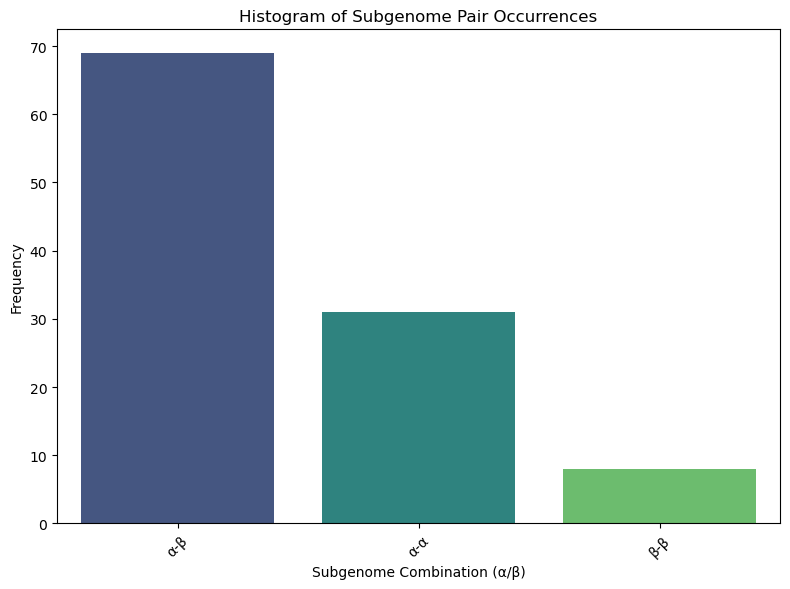

In [25]:

# Assuming df_wgd_lca_parsed_subg is your dataframe

# Reset the subgenome_combination column
if 'subgenome_combination' in df_wgd_lca_parsed_subg.columns:
    df_wgd_lca_parsed_subg.drop(columns=['subgenome_combination'], inplace=True)

# Create a new column combining both subgenome labels, ignoring numbers and using Greek letters
df_wgd_lca_parsed_subg['subgenome_combination'] = df_wgd_lca_parsed_subg.apply(
    lambda row: '-'.join(sorted([row.iloc[-2].strip('12').replace('alpha', 'α').replace('beta', 'β'),
                                 row.iloc[-1].strip('12').replace('alpha', 'α').replace('beta', 'β')])), axis=1
)

# Count occurrences of each combination
counts = df_wgd_lca_parsed_subg['subgenome_combination'].value_counts()

# Plot histogram
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xlabel('Subgenome Combination (α/β)')
plt.ylabel('Frequency')
plt.title('Histogram of Subgenome Pair Occurrences')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_6813/3478577350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wgd_lca_parsed_subg.drop(columns=['subgenome_combination'], inplace=True)
/tmp/ipykernel_6813/3478577350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wgd_lca_parsed_subg['subgenome_combination'] = df_wgd_lca_parsed_subg.apply(


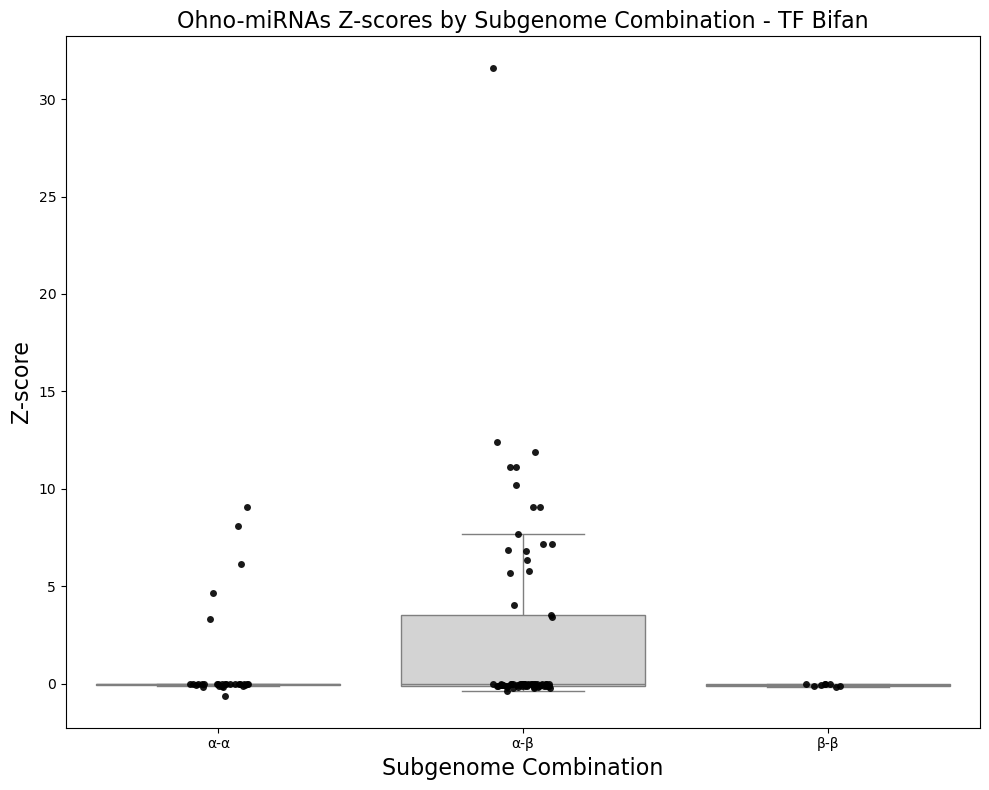

In [28]:
if 'subgenome_combination' in df_wgd_lca_parsed_subg.columns:
    df_wgd_lca_parsed_subg.drop(columns=['subgenome_combination'], inplace=True)

# Create a new column combining both subgenome labels, ignoring numbers and using Greek letters
df_wgd_lca_parsed_subg['subgenome_combination'] = df_wgd_lca_parsed_subg.apply(
    lambda row: '-'.join(sorted([row.iloc[-2].strip('12').replace('alpha', 'α').replace('beta', 'β'),
                                 row.iloc[-1].strip('12').replace('alpha', 'α').replace('beta', 'β')])), axis=1
)

# Boxplot of Z-scores grouped by subgenome combination
plt.figure(figsize=(10, 8))
sns.boxplot(x='subgenome_combination', y='Z-score', data=df_wgd_lca_parsed_subg, order=['α-α', 'α-β', 'β-β'], showfliers=False, color='lightgrey') 
sns.stripplot(x='subgenome_combination', y='Z-score', data=df_wgd_lca_parsed_subg, order=['α-α', 'α-β', 'β-β'], color='black', alpha=0.9, jitter=True)
plt.xlabel('Subgenome Combination', fontsize=16)
plt.ylabel('Z-score', fontsize=16)
plt.title('Ohno-miRNAs Z-scores by Subgenome Combination - TF Bifan', fontsize=16)
plt.tight_layout()
plt.show()

In [27]:
alpha_alpha = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['subgenome_combination'] == 'α-α']['Z-score'].astype(float)
alpha_beta = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['subgenome_combination'] == 'α-β']['Z-score'].astype(float)
beta_beta = df_wgd_lca_parsed_subg[df_wgd_lca_parsed_subg['subgenome_combination'] == 'β-β']['Z-score'].astype(float)
ks_stat_aa_ab, ks_p_value_aa_ab = stats.ks_2samp(alpha_alpha, alpha_beta)
ks_stat_ab_bb, ks_p_value_ab_bb = stats.ks_2samp(alpha_beta, beta_beta)
ks_stat_aa_bb, ks_p_value_aa_bb = stats.ks_2samp(alpha_alpha, beta_beta)

print(f"KS test results for subgenome combinations:\nnetwork={network}\ntarget_homology={target_homology}\nremove_pre_2R={remove_SSD_pre_2R}")
print(100 * "=")
print(f"KS statistic (α-α vs α-β): {ks_stat_aa_ab}, p-value: {ks_p_value_aa_ab}")
print(f"KS statistic (α-β vs β-β): {ks_stat_ab_bb}, p-value: {ks_p_value_ab_bb}")
print(f"KS statistic (α-α vs β-β): {ks_stat_aa_bb}, p-value: {ks_p_value_aa_bb}")

KS test results for subgenome combinations:
network=tarbase
target_homology=mix
remove_pre_2R=False
KS statistic (α-α vs α-β): 0.1477325853202431, p-value: 0.6712464185937091
KS statistic (α-β vs β-β): 0.286231884057971, p-value: 0.5111096650400245
KS statistic (α-α vs β-β): 0.4274193548387097, p-value: 0.14455731793193094
